# S&P 500 prediction

`Dataset to prepare:` 
* (t)&(t-1) historical stock price (Yahoo Finance)
* oil & gas price (Yahoo Finance), 
* unemployment rate (US Bureau of Labor), 
* prime rate (banks), 
* `short sale volume(FINRA API)`, 
* Other stock exchange index(Hang seng, Zurich), 
* trading volume (Yahoo Finance)
* CPI (US Bureau of Labor), 
* Bond yield(treasury bond/bill) (Yahoo Finance), 

* +a: future price (crude oil etc)     

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Oldest date is 1928-01-06 (Volume records since 1951-Dec-24)
SP = pd.read_csv('data/S&P500.csv')
SP['Date']= pd.to_datetime(SP['Date'])
SP['Year'] = SP['Date'].dt.year
SP['Month'] = SP['Date'].dt.month
SP['Day'] = SP['Date'].dt.day

# Manually converting 2027 ~ 2072 to Year 1927 ~ 1972 and combine 'Date' again
SP['Year'] = np.where((SP['Year'] >= 2027), SP['Year'] - 100, SP.Year)
SP['Date_adj'] = pd.to_datetime(SP[['Year','Month','Day']])
SP = SP.drop(['Date','Year','Month','Day'], axis=1)
SP = SP.rename(columns = {'Open':'S&P_Open','Close*':'S&P_Close','Volume':'S&P_Volume','Date_adj':'Date'})
SP = SP.set_index('Date')
SP.replace(to_replace=',', value='', inplace=True, regex = True)
SP.replace(to_replace='-', value=np.nan, inplace=True)

In [3]:
SP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23783 entries, 2022-09-02 to 1927-12-30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   S&P_Open     23783 non-null  object
 1   High         23783 non-null  object
 2   Low          23783 non-null  object
 3   S&P_Close    23783 non-null  object
 4   Adj Close**  23783 non-null  object
 5   S&P_Volume   18287 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


In [4]:
# Oldest date is 1955-08-04
Prime = pd.read_csv('data/prime_rate.csv')
Prime['Date']= pd.to_datetime(Prime['DATE'])
Prime = Prime.drop('DATE', axis=1)
Prime.tail()

,PRIME,Date
346,3.25,2020-03-16
347,3.50,2022-03-17
348,4.00,2022-05-05
349,4.75,2022-06-16
350,5.50,2022-07-28


In [5]:
# Oldest date is 1960-01-04
treasury_3m = pd.read_csv('data/treasury_3m_yield.csv')
treasury_3m['Date']= pd.to_datetime(treasury_3m['Date'])
treasury_3m = treasury_3m[['Date','Close']]
treasury_3m = treasury_3m.rename(columns={'Close':'t_3m_Close'})
treasury_3m.tail()

,Date,t_3m_Close
19476,2022-08-26,2.755
19477,2022-08-28,NaN
19478,2022-08-29,2.798
19479,2022-08-30,2.873
19480,2022-08-31,2.860


In [6]:
# Oldest date is 1962-01-04
treasury_10y = pd.read_csv('data/treasury_10yr_yield.csv')
treasury_10y['Date']= pd.to_datetime(treasury_10y['Date'])
treasury_10y = treasury_10y[['Date','Close']]
treasury_10y = treasury_10y.rename(columns={'Close':'t_10y_Close'})
treasury_10y.tail()

,Date,t_10y_Close
18851,2022-08-26,3.035
18852,2022-08-28,-
18853,2022-08-29,3.11
18854,2022-08-30,3.11
18855,2022-08-31,3.133


In [7]:
cpi = pd.read_csv('data/CPI.csv')
cpi['Month'] = cpi['Period'].str.replace('M','').astype(int)
cpi['Day'] = "01"
cpi['Date'] = pd.to_datetime(cpi[['Year','Month','Day']])
cpi = cpi.drop(['Year','Period','Month','Day','Series Id'], axis=1)
cpi = cpi.rename(columns={'Value':'cpi_Value','1-Month percent change':'cpi_MoM%'})
cpi.head(2)

,cpi_Value,cpi_MoM%,Date
0,21.48,0.7,1947-01-01
1,21.62,1.8,1947-02-01


In [8]:
# Oldest info - 2000-08-23
oil = pd.read_csv('data/Crude_1986.csv')
oil['Date'] = pd.to_datetime(oil['Date'])
oil = oil.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'oil_Price'})
'''
oil = oil.drop(['Open','High','Low','Adj Close**'], axis=1)
oil['Date'] = pd.to_datetime(oil['Date'])
oil = oil.rename(columns={'Close*':'oil_Close','Volume':'oil_Volume'})
'''
oil.tail(2)

,Date,oil_Price
9235,2022-08-26,93.63
9236,2022-08-29,97.40


In [9]:
unemployment = pd.read_csv('data/unemployment_rate.csv')
unemployment['Month'] = unemployment['Period'].str.replace('M','').astype(int)
unemployment['Day'] = "01"
unemployment['Date'] = pd.to_datetime(unemployment[['Year','Month','Day']])
unemployment = unemployment.drop(['Year','Period','Month','Day', 'Series id'], axis=1)
unemployment = unemployment.rename(columns={'Value':'unemp_rate'})
unemployment.head(2)

,unemp_rate,Date
0,3.4,1948-01-01
1,3.8,1948-02-01


In [10]:
# Merging all data into one file
Filename = [treasury_3m, treasury_10y,cpi, oil, unemployment]

SP_all = SP.merge(Prime, on='Date', how='left')
for file in Filename:
    SP_all = SP_all.merge(file, on='Date', how='left')

In [12]:
cols_tofill = ['PRIME','t_3m_Close','t_10y_Close','unemp_rate','cpi_Value',
               'cpi_MoM%','oil_Price']

for col in cols_tofill:
    SP_all[col].fillna(method='bfill', inplace=True)         

In [13]:
SP_all[['S&P_Open','S&P_Close','S&P_Volume','t_10y_Close']] = SP_all[['S&P_Open','S&P_Close','S&P_Volume','t_10y_Close']].astype(float)

In [14]:
SP_all.head()

,Date,S&P_Open,High,Low,S&P_Close,Adj Close**,S&P_Volume,PRIME,t_3m_Close,t_10y_Close,cpi_Value,cpi_MoM%,oil_Price,unemp_rate
0,2022-09-02,3994.66,4018.43,3906.21,3924.26,3924.26,4.134920e+09,5.5,2.860,3.133,295.271,0.0,97.4,3.5
1,2022-09-01,3936.73,3970.23,3903.65,3966.85,3966.85,3.754570e+09,5.5,2.860,3.133,295.271,0.0,97.4,3.5
2,2022-08-31,4000.67,4015.37,3954.53,3955.00,3955.00,3.797860e+09,5.5,2.860,3.133,295.271,0.0,97.4,3.5
3,2022-08-30,4041.25,4044.98,3965.21,3986.16,3986.16,3.190580e+09,5.5,2.873,3.110,295.271,0.0,97.4,3.5
4,2022-08-29,4034.58,4062.99,4017.42,4030.61,4030.61,2.963020e+09,5.5,2.798,3.110,295.271,0.0,97.4,3.5


In [15]:
SP_merged = SP_all[SP_all['Date'] >= '1986-01-02']

In [16]:
SP_merged = SP_merged.set_index('Date')

### EDA 

In [17]:
# Summary statistics
SP_merged.describe()

,S&P_Open,S&P_Close,S&P_Volume,PRIME,t_3m_Close,t_10y_Close,cpi_Value,cpi_MoM%,oil_Price,unemp_rate
count,9244.000000,9244.000000,9.244000e+03,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000
mean,1347.720780,1347.967301,2.115371e+09,6.086110,2.961166,4.705301,190.554060,0.240383,45.729686,5.864756
std,993.256052,993.266714,1.841975e+09,2.410798,2.487474,2.318876,47.617564,0.279072,29.506636,1.651208
min,203.490000,203.490000,1.499000e+07,3.250000,-0.105000,0.499000,108.700000,-1.800000,-36.980000,3.500000
25%,483.040000,483.155000,3.225325e+08,3.500000,0.240000,2.627500,150.900000,0.100000,19.950000,4.700000
50%,1170.315000,1170.345000,1.527440e+09,6.000000,2.833500,4.533000,187.400000,0.200000,35.125000,5.600000
75%,1647.390000,1649.785000,3.565208e+09,8.250000,5.040000,6.513000,232.900000,0.400000,66.102500,6.825000
max,4804.510000,4796.560000,1.145623e+10,11.500000,9.100000,10.230000,295.328000,1.400000,145.310000,14.700000


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

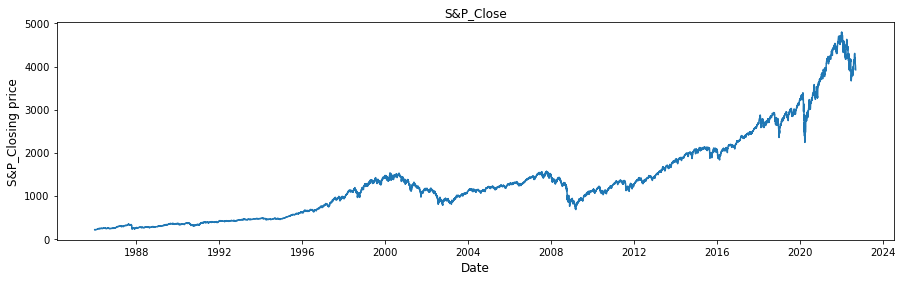

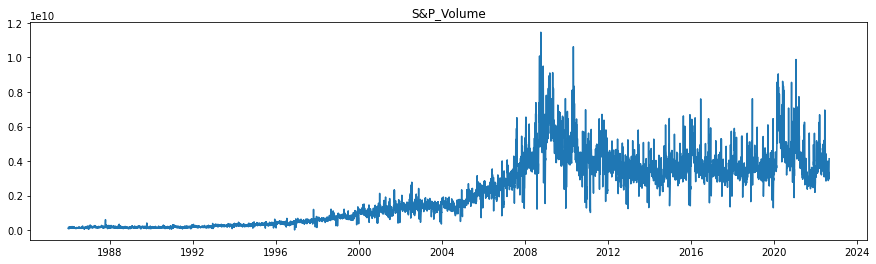

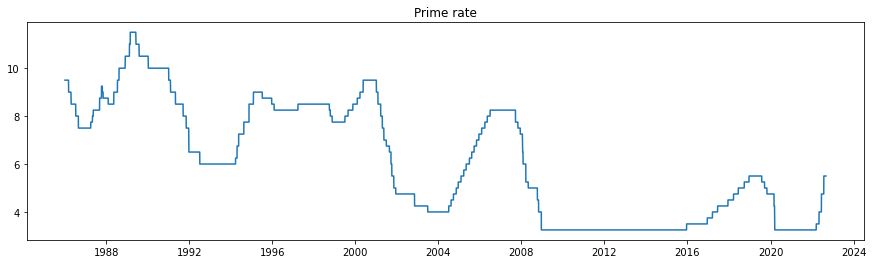

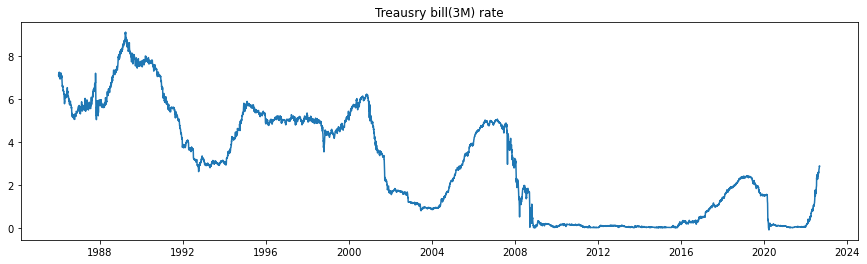

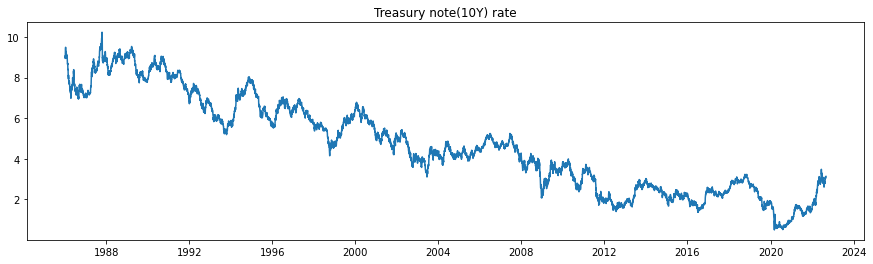

In [22]:
#visualize the data
plt.figure(figsize=(15,4))
plt.title('S&P_Close')
plt.xlabel('Date',fontsize=12)
plt.ylabel('S&P_Closing price',fontsize=12)
plt.plot(SP_merged['S&P_Close'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('S&P_Volume')
plt.plot(SP_merged['S&P_Volume'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Prime rate')
plt.plot(SP_merged['PRIME'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Treausry bill(3M) rate')
plt.plot(SP_merged['t_3m_Close'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Treasury note(10Y) rate')
plt.plot(SP_merged['t_10y_Close'])
plt.show()


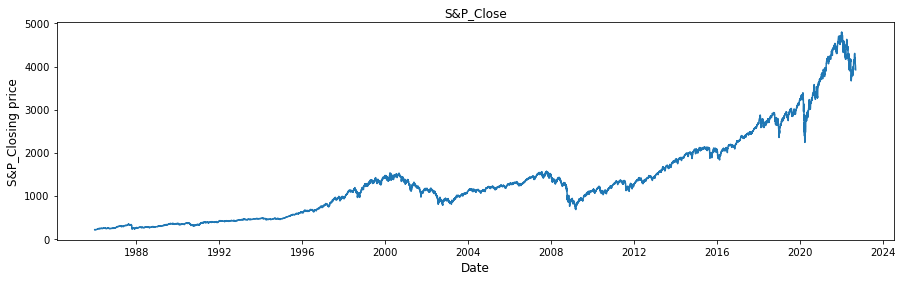

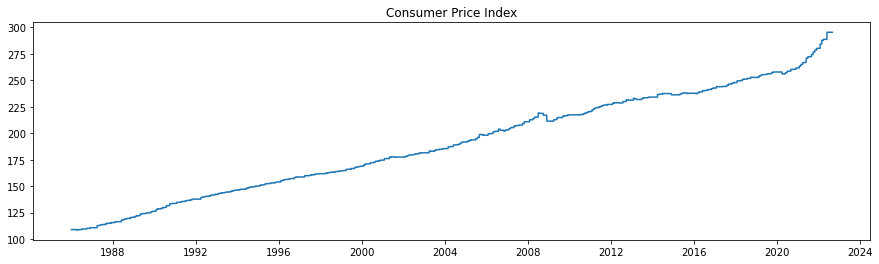

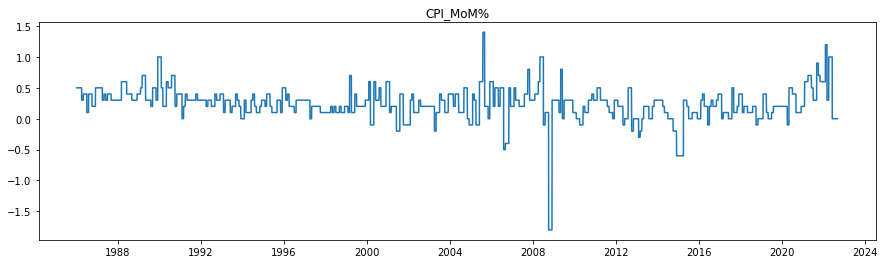

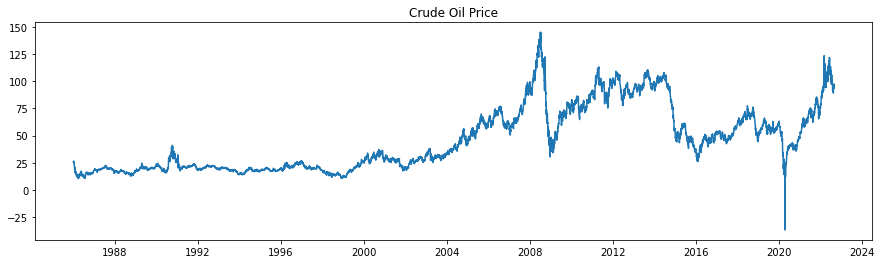

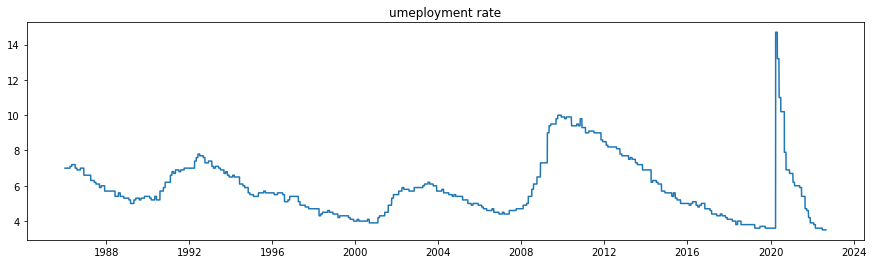

In [23]:
#visualize the data
plt.figure(figsize=(15,4))
plt.title('S&P_Close')
plt.xlabel('Date',fontsize=12)
plt.ylabel('S&P_Closing price',fontsize=12)
plt.plot(SP_merged['S&P_Close'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Consumer Price Index')
plt.plot(SP_merged['cpi_Value'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('CPI_MoM%')
plt.plot(SP_merged['cpi_MoM%'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Crude Oil Price')
plt.plot(SP_merged['oil_Price'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('umeployment rate')
plt.plot(SP_merged['unemp_rate'])
plt.show()


#### Baseline model _ first trial to see how the data is correlated 

In [24]:
y = SP_merged['S&P_Close']
X = SP_merged.drop(['S&P_Close','S&P_Open'], axis=1)

In [25]:
y = y
X = X

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Scaled_X = scaler.fit_transform(X)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Scaled_X, y, test_size=0.33, random_state=42)

In [31]:
Scaled_X = sm.add_constant(Scaled_X)
model = sm.OLS(y,Scaled_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              S&P_Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.011e+30
Date:                Sat, 03 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:15:52   Log-Likelihood:             2.1448e+05
No. Observations:                9244   AIC:                        -4.289e+05
Df Residuals:                    9232   BIC:                        -4.288e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1347.9673   2.11e-13   6.38e+15      0.0